In [39]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR

# Step 1: 加载 CSV 文件并处理日期
file_path = './HFMD_CVAR.csv'
data = pd.read_csv(file_path)

# 处理日期列，将其转换为 datetime 格式并设置为索引
data['日期'] = pd.to_datetime(data['日期'], format='%Y%m%d')
data.set_index('日期', inplace=True)
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]

# 查看数据基本信息
print("数据预览：")
print(data.head())
print(data.info())

# Step 2: 剔除不需要的列并筛选变量
# 剔除 'Score', 'Ratio', 'Number' 列
X = data.drop(columns=['Score', 'Ratio', 'Number', 'Rate'])  # 自变量
Y = data['Rate']  # 目标变量

# 合并 X 和 Y 为一个完整数据框
hfmd = pd.concat([Y, X], axis=1)
print("\n筛选后的数据：")
print(hfmd.head())


数据预览：
            AQI  PM2_5  PM10  SO2  NO2  O3_8h    CO  Temperature  Pressure  \
日期                                                                           
2015-01-01   62     37    74   29   45     61  0.78            3     776.2   
2015-01-02  104     78   113   48   80     41  1.30            5     773.9   
2015-01-03  129     98   129   39   78     54  1.23            7     769.6   
2015-01-04  167    127   160   51  119     37  1.62           13     764.3   
2015-01-05  105     79   145   27   82     51  1.03           16     760.5   

            Humidity  Wind    Score     Ratio  Number    Rate  
日期                                                             
2015-01-01        33     6  209.733  0.029737    1366  5.6257  
2015-01-02        33     3  221.966  0.031471    1446  5.9551  
2015-01-03        57     5  231.664  0.032846    1509  6.2146  
2015-01-04        47     2  241.927  0.034301    1576  6.4905  
2015-01-05        68     6  225.790  0.032013    1471  6.0581  

In [40]:
# Step 3: 划分数据集
# 定义预测集的时间范围
prediction_start = '2020-02-02'
train_end = '2020-02-01'
# 将数据划分为训练集和预测集
train_data = hfmd.loc[:train_end]
prediction_data = hfmd.loc[prediction_start:]

print("\n训练集：")
print(train_data.tail())
print("\n预测集：")
print(prediction_data.head())



训练集：
              Rate  AQI  PM2_5  PM10  SO2  NO2  O3_8h    CO  Temperature  \
日期                                                                         
2020-01-28  1.5608  110     83    66    6   25     62  1.10            6   
2020-01-29  1.5155   91     68    55    8   22    102  0.93            8   
2020-01-30  1.5197   95     71    59    9   22     98  1.08            5   
2020-01-31  1.4620   67     49    41    9   34     89  0.90            6   
2020-02-01  0.0617   56     30    26    7   45     81  0.67            8   

            Pressure  Humidity  Wind  
日期                                    
2020-01-28     767.3        76     4  
2020-01-29     768.1        57     5  
2020-01-30     768.1        57     7  
2020-01-31     770.4        53     3  
2020-02-01     771.9        46     1  

预测集：
              Rate  AQI  PM2_5  PM10  SO2  NO2  O3_8h    CO  Temperature  \
日期                                                                         
2020-02-02  0.0617   51     36

In [41]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# Step 3: 平稳性检验和差分处理
# ADF 测试函数
def adf_test(series, name=''):
    result = adfuller(series.dropna())
    p_value = result[1]
    is_stationary = p_value < 0.05
    print(f"ADF Test for {name}: p-value = {p_value:.4f}, {'Stationary' if is_stationary else 'Non-Stationary'}")
    return is_stationary

# 检查每列是否平稳
print("\n平稳性检验结果：")
for column in train_data.columns:
    adf_test(train_data[column], name=column)

# 对不平稳的列进行差分
var_data_diff = train_data.diff().dropna()  # 一阶差分
print("\n差分后的数据：")
print(var_data_diff.head())

# Step 4: 构建 VAR 模型
# 创建 VAR 模型
print("\n构建 VAR 模型：")
var_model = VAR(var_data_diff)
var_results = var_model.fit(maxlags=5, ic='aic')  # 自动选择最佳滞后阶数
print(var_results.summary())



平稳性检验结果：
ADF Test for Rate: p-value = 0.0408, Stationary
ADF Test for AQI: p-value = 0.0000, Stationary
ADF Test for PM2_5: p-value = 0.0000, Stationary
ADF Test for PM10: p-value = 0.0000, Stationary
ADF Test for SO2: p-value = 0.0031, Stationary
ADF Test for NO2: p-value = 0.0000, Stationary
ADF Test for O3_8h: p-value = 0.0005, Stationary
ADF Test for CO: p-value = 0.0000, Stationary
ADF Test for Temperature: p-value = 0.1926, Non-Stationary
ADF Test for Pressure: p-value = 0.0837, Non-Stationary
ADF Test for Humidity: p-value = 0.0000, Stationary
ADF Test for Wind: p-value = 0.0000, Stationary

差分后的数据：
              Rate   AQI  PM2_5  PM10   SO2   NO2  O3_8h    CO  Temperature  \
日期                                                                            
2015-01-02  0.3294  42.0   41.0  39.0  19.0  35.0  -20.0  0.52          2.0   
2015-01-03  0.2595  25.0   20.0  16.0  -9.0  -2.0   13.0 -0.07          2.0   
2015-01-04  0.2759  38.0   29.0  31.0  12.0  41.0  -17.0  0.39       

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [42]:

# 计算 VIF 的函数
def calculate_vif(dataframe):
    """
    计算给定 DataFrame 中每个特征的 VIF 值。
    :param dataframe: 包含回归变量的 DataFrame
    :return: VIF 值 DataFrame
    """
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

# 对差分后的数据计算 VIF（因为 VAR 模型使用差分后的数据）
print("\n计算 VIF 指标：")
vif_df = calculate_vif(var_data_diff)
print(vif_df)




计算 VIF 指标：
        Feature       VIF
0          Rate  1.194963
1           AQI  5.706822
2         PM2_5  8.302320
3          PM10  4.437234
4           SO2  2.467963
5           NO2  2.794192
6         O3_8h  2.356101
7            CO  5.623965
8   Temperature  2.105461
9      Pressure  2.122038
10     Humidity  2.307916
11         Wind  1.466257


In [43]:
import numpy as np
import pandas as pd
from statsmodels.tsa.vector_ar.vecm import coint_johansen

# 示例数据
data = train_data

# Johansen Cointegration Test
test_result = coint_johansen(data, det_order=1, k_ar_diff=3)

# 自定义格式化输出函数
def johansen_summary(result):
    print("=== Johansen Cointegration Test Summary ===\n")
    print("Eigenvalues:")
    print(result.eig, "\n")
    
    print("Trace Statistic:")
    print(result.lr1)
    print("Critical Values (Trace):")
    print(result.cvt, "\n")
    
    print("Max-Eigen Statistic:")
    print(result.lr2)
    print("Critical Values (Max-Eigen):")
    print(result.cvm, "\n")
    
    print("------------------------------------------------")
    print("Decision based on Trace Test:")
    for i, (stat, crit) in enumerate(zip(result.lr1, result.cvt[:, 1])):  # Compare with 95% critical values
        print(f"H0: Rank <= {i} | Trace Statistic: {stat:.4f} | Critical Value (95%): {crit:.4f} | {'Reject' if stat > crit else 'Fail to Reject'}")
    
    print("\nDecision based on Max-Eigen Test:")
    for i, (stat, crit) in enumerate(zip(result.lr2, result.cvm[:, 1])):  # Compare with 95% critical values
        print(f"H0: Rank <= {i} | Max-Eigen Statistic: {stat:.4f} | Critical Value (95%): {crit:.4f} | {'Reject' if stat > crit else 'Fail to Reject'}")

# 输出结果
johansen_summary(test_result)

=== Johansen Cointegration Test Summary ===

Eigenvalues:
[0.21050374 0.18554829 0.14771044 0.137155   0.12954119 0.11571432
 0.10488846 0.09706641 0.06994465 0.0448996  0.01473054 0.00462361] 

Trace Statistic:
[2524.2155432  2086.00376752 1705.48855073 1409.16568568 1135.66322223
  878.44882719  650.45299913  445.01691857  255.71189998  121.27617849
   36.10561655    8.59204671]
Critical Values (Trace):
[[350.1125 358.719  375.3203]
 [298.8836 306.8988 322.4264]
 [251.6293 259.0267 273.3838]
 [208.3582 215.1268 228.2226]
 [169.0618 175.1584 187.1891]
 [133.7852 139.278  150.0778]
 [102.4674 107.3429 116.9829]
 [ 75.1027  79.3422  87.7748]
 [ 51.6492  55.2459  62.5202]
 [ 32.0645  35.0116  41.0815]
 [ 16.1619  18.3985  23.1485]
 [  2.7055   3.8415   6.6349]] 

Max-Eigen Statistic:
[438.21177568 380.51521679 296.32286505 273.50246345 257.21439504
 227.99582805 205.43608057 189.30501859 134.43572148  85.17056194
  27.51356985   8.59204671]
Critical Values (Max-Eigen):
[[76.4081 79.9878 

In [44]:
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import VECM, select_order
import numpy as np

# Step 6: 检查是否存在共整合关系（Johansen Cointegration Test）
print("\n共整合关系检验：")
# 检测滞后阶数
vecm_order = select_order(data=train_data, maxlags=20, deterministic="ci")
print(f"Selected lag order: {vecm_order.summary()}")

# 提取滞后阶数，用于共整合分析
optimal_lag = vecm_order.selected_orders['aic']  # 使用 AIC 选择的最佳滞后阶数
print(f"Optimal lag (HQIC): {optimal_lag}")



共整合关系检验：


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  

Selected lag order:  VECM Order Selection (* highlights the minimums) 
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        34.70      35.20*   1.171e+15       34.88
1        34.43       35.37   8.973e+14      34.78*
2        34.37       35.74   8.463e+14       34.88
3       34.36*       36.17  8.404e+14*       35.03
4        34.37       36.60   8.420e+14       35.19
5        34.40       37.07   8.705e+14       35.38
6        34.43       37.53   8.964e+14       35.57
7        34.46       37.99   9.220e+14       35.76
8        34.51       38.48   9.763e+14       35.97
9        34.55       38.95   1.014e+15       36.17
10       34.61       39.44   1.075e+15       36.39
11       34.66       39.92   1.132e+15       36.60
12       34.69       40.39   1.173e+15       36.79
13       34.77       40.90   1.268e+15       37.03
14       34.83       41.38   1.342e+15       37.24
15       34.88       41.87   1.424e+15       37.46
16       34

In [49]:
# Step 7: 使用 Granger 因果分析筛选变量
print("\nGranger Causality Analysis：")
selected_vars = ['Rate']  # 初始保留目标变量 'Rate'

for column in train_data.columns:
    if column != 'Rate':  # 不对目标变量本身进行检验
        print(f"\nTesting Granger causality between 'Rate' and '{column}':")
        result = grangercausalitytests(train_data[['Rate', column]].dropna(), optimal_lag, verbose=False)
        p_values = [round(result[i + 1][0]['ssr_chi2test'][1], 4) for i in range(optimal_lag)]  # 提取每个滞后阶数的 p 值
        print(f"P-values for lags 1 to {optimal_lag}: {p_values}")
        # 如果任何滞后阶数的 p 值小于 0.05，保留该变量
        if all(p < 0.05 for p in p_values):
            selected_vars.append(column)

print("\nVariables selected by Granger causality analysis：", selected_vars)

# 根据筛选结果构建新的数据集
train_data = train_data[selected_vars]
prediction_data = prediction_data[selected_vars]



Granger Causality Analysis：

Testing Granger causality between 'Rate' and 'AQI':
P-values for lags 1 to 3: [0.0, 0.0, 0.0]

Testing Granger causality between 'Rate' and 'PM2_5':
P-values for lags 1 to 3: [0.0, 0.0, 0.0001]

Testing Granger causality between 'Rate' and 'PM10':
P-values for lags 1 to 3: [0.0, 0.0, 0.0]

Testing Granger causality between 'Rate' and 'SO2':
P-values for lags 1 to 3: [0.0011, 0.0042, 0.0081]

Testing Granger causality between 'Rate' and 'NO2':
P-values for lags 1 to 3: [0.0403, 0.013, 0.031]

Testing Granger causality between 'Rate' and 'CO':
P-values for lags 1 to 3: [0.0, 0.0003, 0.0007]

Testing Granger causality between 'Rate' and 'Pressure':
P-values for lags 1 to 3: [0.0018, 0.0071, 0.0097]

Testing Granger causality between 'Rate' and 'Humidity':
P-values for lags 1 to 3: [0.0019, 0.0054, 0.0025]

Variables selected by Granger causality analysis： ['Rate', 'AQI', 'PM2_5', 'PM10', 'SO2', 'NO2', 'CO', 'Pressure', 'Humidity']


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since function

In [46]:

#Step 8: 检测共整合关系
vecm_model = VECM(train_data, k_ar_diff=optimal_lag, deterministic="ci")  # "ci" 表示包含常数项
johansen_test = vecm_model.fit()
print("\nJohansen Test Results:")
print(johansen_test.summary())



Johansen Test Results:
Det. terms outside the coint. relation & lagged endog. parameters for equation Rate
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
L1.Rate        -0.0410      0.025     -1.641      0.101      -0.090       0.008
L1.AQI         -0.0078      0.002     -3.155      0.002      -0.013      -0.003
L1.PM2_5        0.0056      0.005      1.116      0.265      -0.004       0.015
L1.PM10        -0.0015      0.003     -0.548      0.584      -0.007       0.004
L1.SO2         -0.0206      0.014     -1.425      0.154      -0.049       0.008
L1.NO2          0.0103      0.004      2.562      0.010       0.002       0.018
L1.CO           0.1462      0.424      0.345      0.730      -0.685       0.978
L1.Pressure    -0.0007      0.016     -0.043      0.965      -0.031       0.030
L1.Humidity    -0.0056      0.004     -1.507      0.132      -0.013       0.002
L2.Rate     

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [47]:

# Step 9: 构建 CVAR 模型
print("\n构建 CVAR 模型：")
cvar_model = VECM(train_data, k_ar_diff=optimal_lag, deterministic="ci")
cvar_results = cvar_model.fit()

# 输出模型的参数估计结果
print("\nCVAR 模型拟合结果：")
print(cvar_results.summary())



构建 CVAR 模型：

CVAR 模型拟合结果：
Det. terms outside the coint. relation & lagged endog. parameters for equation Rate
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
L1.Rate        -0.0410      0.025     -1.641      0.101      -0.090       0.008
L1.AQI         -0.0078      0.002     -3.155      0.002      -0.013      -0.003
L1.PM2_5        0.0056      0.005      1.116      0.265      -0.004       0.015
L1.PM10        -0.0015      0.003     -0.548      0.584      -0.007       0.004
L1.SO2         -0.0206      0.014     -1.425      0.154      -0.049       0.008
L1.NO2          0.0103      0.004      2.562      0.010       0.002       0.018
L1.CO           0.1462      0.424      0.345      0.730      -0.685       0.978
L1.Pressure    -0.0007      0.016     -0.043      0.965      -0.031       0.030
L1.Humidity    -0.0056      0.004     -1.507      0.132      -0.013       0.002
L2.Rate  

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


R²: 0.9783
MSE: 2.7233
RMSE: 1.6502
MAE: 0.6259
MAPE: 7.6130%


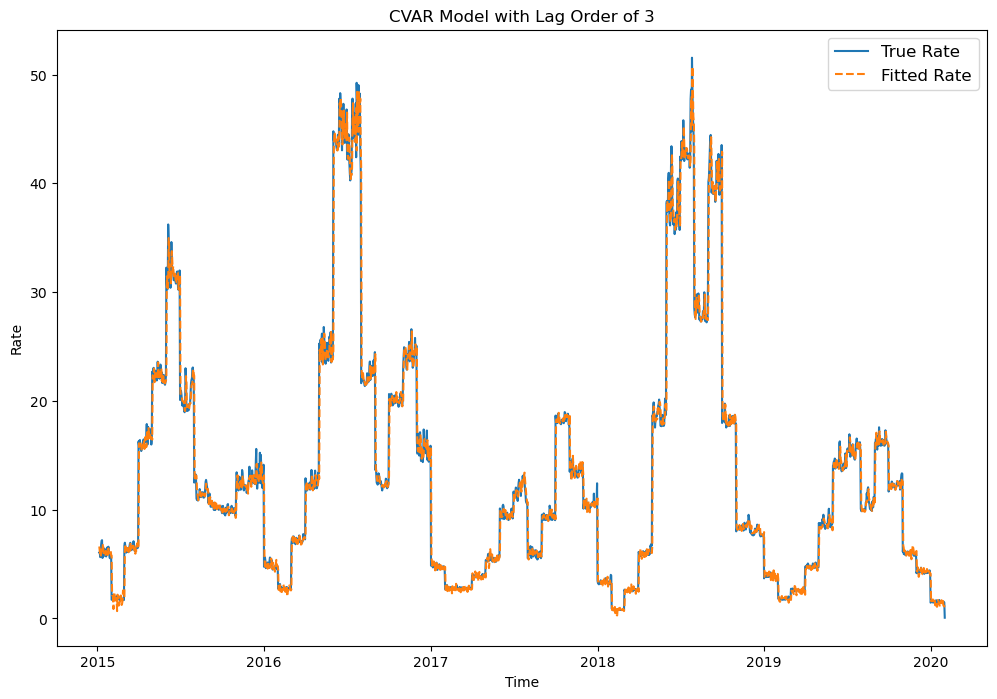

In [53]:
import pandas as pd
import matplotlib.pyplot as plt

# 将拟合值转换为 DataFrame，列名与 cvar_data 对应
y_pred = pd.DataFrame(cvar_results.fittedvalues, 
                      index=train_data.index[optimal_lag+1:],  # 添加索引
                      columns=train_data.columns)

# 提取需要的列，例如 "Rate"
y_true = train_data["Rate"].iloc[optimal_lag+1:]
y_pred_rate = y_pred["Rate"]

# 计算评价指标
r_squared = 1 - np.sum((y_true - y_pred_rate)**2) / np.sum((y_true - np.mean(y_true))**2)
mse = np.mean((y_true - y_pred_rate)**2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true - y_pred_rate))
mape = np.mean(np.abs((y_true - y_pred_rate) / y_true)) * 100

# 输出结果
print(f"R²: {r_squared:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.4f}%")


# 绘制真实值与拟合值对比曲线
plt.figure(figsize=(12, 8))  # 调整图形大小
plt.plot(y_true.index, y_true, label="True Rate",linestyle='-')  # 蓝色线条，增加宽度
plt.plot(y_true.index, y_pred_rate, label="Fitted Rate", linestyle='--')  # 红色线条，增加宽度

# 添加标题和轴标签，调整字体大小
plt.title("CVAR Model with Lag Order of 3")
plt.xlabel("Time")
plt.ylabel("Rate")

# 添加图例，调整位置和字体大小
plt.legend(fontsize=12, loc="best")

# 显示图表
plt.show()

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VECM

# 定义滚动预测函数
def rolling_forecast(train_data, prediction_data, steps, optimal_lag, target_column):
    forecast_values = []
    true_values = prediction_data[target_column].values  # 提取真实值
    forecast_index = prediction_data.index  # 获取预测时间索引

    # 滚动预测逻辑
    for i in range(0, len(prediction_data) - steps, steps):
        # 当前训练数据包含前 i 条预测集的真实值
        current_train_data = pd.concat([train_data, prediction_data.iloc[:i]])
        
        # 训练 CVAR 模型
        cvar_model = VECM(current_train_data, k_ar_diff=optimal_lag, deterministic="ci")
        cvar_results = cvar_model.fit()
        
        # 进行预测
        future_steps = min(steps, len(prediction_data) - i)
        forecast = cvar_results.predict(steps=future_steps)
        
        # 保存预测值（只保存目标变量的预测值）
        forecast_values.extend(forecast[:, 0])  # 假设目标变量是第一列

    return pd.DataFrame({
        "Date": forecast_index[:len(forecast_values)],
        "Predicted": forecast_values,
        "Actual": true_values[:len(forecast_values)]
    }).set_index("Date")

# 设置滚动预测参数
steps = 3 # 每次预测步数
optimal_lag = 3  # 滞后阶数（根据模型调整）
target_column = "Rate"  # 目标列

# 调用滚动预测函数
rolling_results = rolling_forecast(train_data, prediction_data, steps, optimal_lag, target_column)


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  

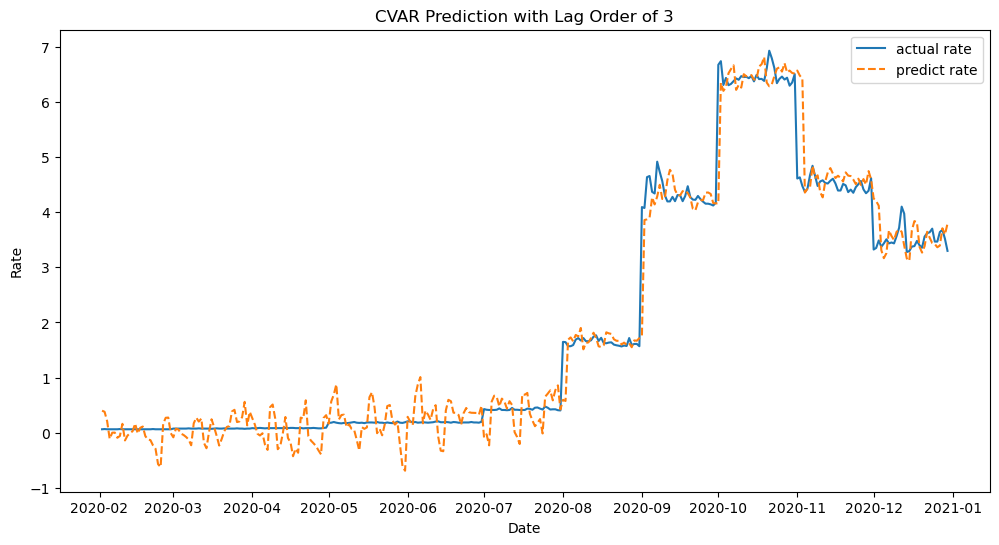

R²: 0.9696
MSE: 0.1511
RMSE: 0.3887
MAE: 0.2472
MAPE: 1.1048


In [55]:

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# 可视化预测值和真实值
plt.figure(figsize=(12, 6))
plt.plot(rolling_results.index, rolling_results["Actual"], label="actual rate", linestyle="-")
plt.plot(rolling_results.index, rolling_results["Predicted"], label="predict rate", linestyle="--")
plt.title("CVAR Prediction with Lag Order of 3")
plt.xlabel("Date")
plt.ylabel("Rate")
plt.legend()
plt.show()

# 计算 R²
ss_total = ((rolling_results["Actual"] - rolling_results["Actual"].mean()) ** 2).sum()
ss_residual = ((rolling_results["Actual"] - rolling_results["Predicted"]) ** 2).sum()
r_squared = 1 - (ss_residual / ss_total)

# 计算 MSE、RMSE、MAE、MAPE
mse = mean_squared_error(rolling_results["Actual"], rolling_results["Predicted"])
rmse = np.sqrt(mse)
mae = mean_absolute_error(rolling_results["Actual"], rolling_results["Predicted"])
mape = mean_absolute_percentage_error(rolling_results["Actual"], rolling_results["Predicted"])

# 输出结果
print(f"R²: {r_squared:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.4f}")